Importing & reading in data

In [53]:
from requests import get
from pandas import DataFrame, concat, to_datetime, Timedelta, json_normalize
from time import time
import numpy as np
from seaborn import set, distplot
import matplotlib.pyplot as plt
from math import ceil
from plotly.graph_objects import Scatter
import plotly.figure_factory as ff
from plotly.express import colors
from dotenv import load_dotenv
from datetime import datetime
from time import time
import json, os

In [54]:
fetchSaleData = True
fetchReturnData = True

lastUpdatedInDays = 1

In [55]:
# current time
currentTime = time()
timeToCheckAgainst = datetime.fromtimestamp(currentTime - lastUpdatedInDays*24*60*60)

if not os.path.exists('data files'):
    os.makedirs('data files')

print('Checking for sale data...')
if os.path.exists("./data files/rawSaleData.json"):
    saleDataTime = datetime.fromtimestamp(os.path.getctime('./data files/rawSaleData.json'))
    print('Found sale data from:', saleDataTime.strftime('%c'))
    
    # if older than 'lastUpdatedInDays' days, fetch again
    if saleDataTime <= timeToCheckAgainst:
        print('Locally saved data is older than {} hours!'.format(lastUpdatedInDays*24))
        print('Have to fetch again...')
        fetchSaleData = True
    else:
        print('Will be using this locally saved data...')
        fetchSaleData = False
else:
    print('No local data found!')
    print('Have to fetch again...')
    fetchSaleData = True

print('Checking for return data...')
if os.path.exists("./data files/rawReturnData.json"):
    returnDataTime = datetime.fromtimestamp(os.path.getctime('./data files/rawReturnData.json'))
    print('Found return data from:', returnDataTime.strftime('%c'))
    
    # if older than 'lastUpdatedInDays' days, fetch again
    if returnDataTime <= timeToCheckAgainst:
        print('Locally saved data is older than {} hours!'.format(lastUpdatedInDays*24))
        print('Have to fetch again...')
        fetchReturnData = True
    else:
        print('Will be using this locally saved data...')
        fetchReturnData = False
else:
    print('No local data found!')
    print('Have to fetch again...')
    fetchReturnData = True

Checking for sale data...
Found sale data from: Fri Sep 18 03:39:39 2020
Locally saved data is older than 24 hours!
Have to fetch again...
Checking for return data...
Found return data from: Fri Sep 18 03:40:08 2020
Locally saved data is older than 24 hours!
Have to fetch again...


In [56]:
load_dotenv()

domain = os.getenv("URL")

if fetchSaleData:
    print('Getting Sale data... Please wait!')
    startTime = time()

    # get sale data
    response = get('https://' + domain + 'sale')
    saleData = response.json()

    print('Took', round(time() - startTime, 2), 'seconds to get Sale data.')
    
    # save locally for later reuse
    with open('./data files/rawSaleData.json', 'w') as fp:
        json.dump(saleData, fp, indent=4)
else:
    # use locally saved data
    with open('./data files/rawSaleData.json', 'r') as fp:
        saleData = json.load(fp)

Getting Sale data... Please wait!
Took 47.94 seconds to get Sale data.


In [57]:
if fetchReturnData:
    print('Getting Return data... Please wait!')
    startTime = time()

    # get return data
    response = get('https://' + domain + 'return')
    returnData = response.json()

    print('Took', round(time() - startTime, 2), 'seconds to get Return data.')
    
    # save locally for later reuse
    with open('./data files/rawReturnData.json', 'w') as fp:
        json.dump(returnData, fp, indent=4)
else:
    # use locally saved data
    with open('./data files/rawReturnData.json', 'r') as fp:
        returnData = json.load(fp)

Getting Return data... Please wait!
Took 27.09 seconds to get Return data.


Reading in & cleaning sales data

In [58]:
# build dataframe
saleDF = DataFrame.from_dict(saleData, orient='columns')

# drop columns
saleDF = saleDF.drop(['scanned_at', 'scanned_at_melbourne_date_time'], axis=1)

# rename
saleDF = saleDF.rename(columns={"scanned_at_melbourne_date": "sale_date", "scanned_at_melbourne_time": "sale_time", "id": "sale_id"})

# merging date and time, converting new column to datetime64 datatype
saleDF['date_time_concat'] = saleDF['sale_date'] + ' ' + saleDF['sale_time']
saleDF['date_time'] = to_datetime(saleDF['date_time_concat'], dayfirst=True)
saleDF = saleDF.drop(['sale_date', 'sale_time', 'date_time_concat'], axis=1)

# filter to get records post 22nd Jan
saleDF = saleDF[saleDF['date_time'] >= '2020/01/22 00:00:00']
saleDF = saleDF.sort_values(by='date_time', ascending = True)

# append column 'type' to sale dataframe (sale = 1)
saleDF['current_type'] = 1
saleDF = saleDF.drop('return_id', axis = 1)

saleDF.head()

,sale_id,cup_id,cafe_id,date_time,current_type
4221,4252,8574643943,104,2020-01-22 07:46:57,1
4222,4253,2496593207,104,2020-01-22 07:47:50,1
4223,4254,1590850598,104,2020-01-22 07:48:44,1
4224,4255,7342150520,104,2020-01-22 07:49:25,1
4225,4256,9678996946,104,2020-01-22 07:56:56,1


Reading in & cleaning return data

In [59]:
# build dataframe
returnDF = DataFrame.from_dict(json_normalize(returnData), orient='columns')

# dropping columns
returnDF = returnDF.drop(['scanned_at', 'bin_id', 'cafe_id', 'dishwasher_id'], axis=1)

# renaming columns
returnDF = returnDF.rename(columns={"scanned_at_melbourne_date_time.date": "return_date", "scanned_at_melbourne_date_time.time": "return_time", "id": "return_id"})

# merging date and time, converting new column to datetime64 datatype
returnDF['date_time_concat'] = returnDF['return_date'] + ' ' + returnDF['return_time']
returnDF['date_time'] = to_datetime(returnDF['date_time_concat'], dayfirst=True)
returnDF = returnDF.drop(['return_date', 'return_time', 'date_time_concat'], axis=1)

# filter to get records post 22nd Jan
returnDF = returnDF[returnDF['date_time'] >= '2020/01/22 00:00:00']
returnDF = returnDF.sort_values(by='date_time', ascending = True)

# append column 'type' to return dataframe (retun = 0)
returnDF['current_type'] = 0
returnDF['cafe_id'] = np.nan

returnDF.head()

,return_id,cup_id,date_time,current_type,cafe_id
6243,6244,3815501729,2020-01-22 14:55:40,0,NaN
6244,6245,2397660595,2020-01-22 14:55:42,0,NaN
6245,6246,4897580664,2020-01-22 14:55:43,0,NaN
6246,6247,2486468654,2020-01-22 14:55:44,0,NaN
6247,6248,4498550854,2020-01-22 14:55:45,0,NaN


Concatenate sales and return dataframes, sort rows by date_time

In [60]:
df = concat([saleDF, returnDF], ignore_index=True, sort=False)
df = df[['sale_id', 'return_id', 'current_type', 'cup_id', 'cafe_id', 'date_time']]
df = df.sort_values(by='date_time', ascending = True)
len(df)

8167

Graph #1 (without imputations)

In [61]:
# creates empty list, will fill up with date_time entries later
return_time_list = []
return_duration =[]

# iterating through each unique cup id
for cup in df.cup_id.unique():
    # creates temporary data frame with all sales/returns reocrds of a specifc cup
    temp_df = df[df.cup_id == cup]
    # iterating through all entries for sales entries
    for i in range(0, len(temp_df)-1):
        # limiting duration calculation to only start with sales
        if temp_df.current_type.iloc[i] == 1:
            if temp_df.current_type.iloc[i+1] == 0:
                # finding return time by subtracting next entry time with current entry time
                temp_dict = {"return_time": temp_df.date_time.iloc[i+1] - temp_df.date_time.iloc[i]}
                return_time_list.append(temp_dict)
                return_duration.append((temp_df.date_time.iloc[i+1] - temp_df.date_time.iloc[i])/np.timedelta64(1, 'D'))

return_time_df = DataFrame(return_time_list)

# converting into days
return_time_df.loc[:, "duration_in_days"] = return_time_df["return_time"] / np.timedelta64(1, 'D')

# converting all time > 21 as 21 (maximum threshold)
#for i in range(0, len(return_time_df)):
#  if return_time_df.duration_in_days.iloc[i] >= 21:
#    return_time_df.duration_in_days.iloc[i] = 21

len(return_time_df)

2429

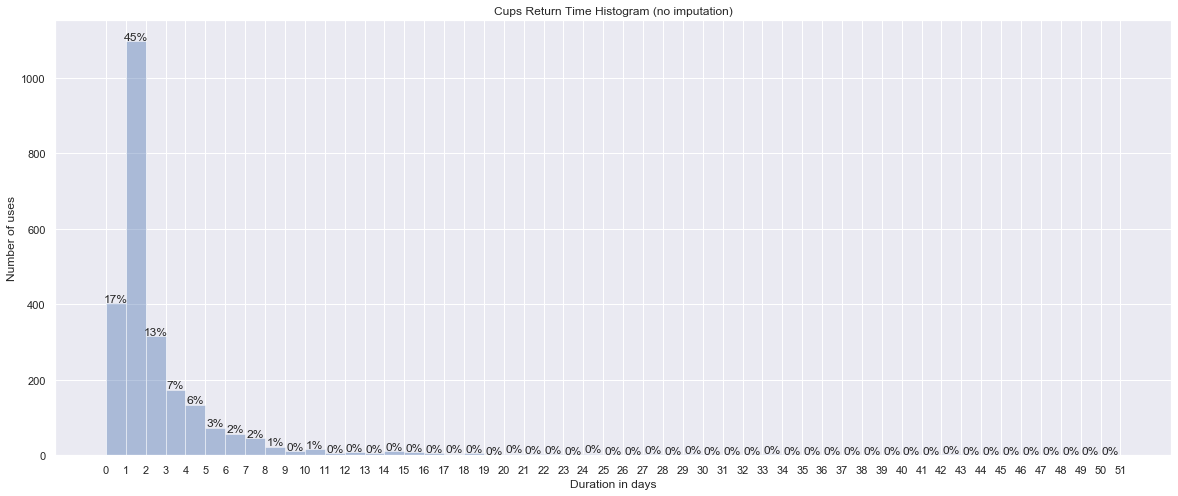

In [62]:
set(style="darkgrid")

fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)

# histogram plot
max_days_value = ceil(max(return_time_df["duration_in_days"])) + 1
distplot(a=return_time_df["duration_in_days"], hist=True, kde=False, rug=False, bins=range(max_days_value))

# Setting the X and Y Label 
plt.xlabel('Duration in days') 
plt.ylabel('Number of uses')

# setting the X and Y ticks
plt.xticks(np.arange(0, max_days_value))
#plt.yticks(np.arange(0, 850, 50))

# setting the title
plt.title('Cups Return Time Histogram (no imputation)')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1}%'.format(int(round(height/len(return_time_df)*100))),
            ha="center") 

plt.show()

In [75]:
for index in range(len(return_duration)):
    if return_duration[index] > 20:
        return_duration[index] = 20.1

# name of the dataset
group_labels = ['Cups return time']

fig = ff.create_distplot([np.array(return_duration)], group_labels, show_rug=False, bin_size=1)
fig.update_layout(xaxis=dict(range=[-1, ceil(max(return_duration))+1]))

fig.update_layout(
    title="Histogram with probability density curve for cups return time (no imputation)",
    xaxis_title="Duration in days",
    yaxis_title="Probability density",
    xaxis = dict(tickmode = 'linear'),
    annotations=[dict(
                      x=0,
                      y=1.1,
                      showarrow=False,
                      text="Instances where the cup returned after 20 days have been boxed in 20-21 days bin.",
                      xref="paper",
                      yref="paper",
                      align="left"
                    )]
    )

fig.update_traces(marker=dict(line=dict(width=1,
                                        color='Black')),
                  nbinsx=21, 
                  autobinx=True, 
                  selector={'type':'histogram'}
                  )

counts, bins = np.histogram(return_duration, bins=range(0, 22, 1))
height = round(max(counts)/sum(counts),2)
percents = [int(round(count/len(return_duration)*100)) for count in counts]

fig.add_trace(Scatter(
    x=[ceil(max(return_duration))],
    y=[height],
    mode="text",
    text='Total uses: {}'.format(len(return_duration)),
    textposition="top left",
    showlegend=False
))

fig.add_trace(Scatter(
    x=np.arange(0.5, ceil(max(return_duration)), 1),
    y=[round(count/len(return_duration),4)+0.005 for count in counts],
    mode="text",
    text=[str(percent) + '%' for percent in percents],
    textposition="top center",
    showlegend=False,
    hoverinfo='skip'
))


fig.show()

In [66]:
return_duration.sort()
frame = DataFrame({'duration': return_duration})
frame.to_csv('./data files/durations.csv', index = False)

Imputation algorithm

In [67]:
# listing all unique cup ids
cup_ids = df.cup_id.unique()
# creates empty data frame, will fill up with imputed entries later
rows_list = []

# iterating through each unique cup id
for cup in cup_ids:
    # creates temporary data frame with all sales/returns records of a specific cup id
    temp_df = df[df.cup_id == cup]
    # if the cup has been used more than once
    if len(temp_df) > 0:
        # iterating from 2nd row of temporary dataframe onwards
        for i in range(1, len(temp_df)):
            # checks if current entry type is same as previous entry type
            if temp_df.current_type.iloc[i] == temp_df.current_type.iloc[i-1]:
                # imputation for a sale (time set 10 hours after return)
                if temp_df.current_type.iloc[i-1] == 0:
                    temp_dict = {"sale_id" : np.nan,
                               "return_id" : np.nan,
                               "current_type" : 1,
                               "cup_id" : cup,
                               "cafe_id" : np.nan,
                               "date_time" : temp_df.date_time.iloc[i-1] + Timedelta(hours=10)
                               }
                    rows_list.append(temp_dict)
                # imputation for a return (time set 10 hours before next sale)
                elif temp_df.current_type.iloc[i-1] == 1:
                    temp_dict = {"sale_id" : np.nan,
                               "return_id" : np.nan,
                               "current_type" : 0,
                               "cup_id" : cup,
                               "cafe_id" :np.nan,
                               "date_time" : temp_df.date_time.iloc[i] - Timedelta(hours=10)
                               }
                    rows_list.append(temp_dict)

impute_df = DataFrame(rows_list)
#print(len(impute_df))

# combine imputed df with original data
df = concat([df, impute_df], ignore_index=True, sort=False)
df = df.sort_values(by='date_time', ascending=True)
len(df)

10343

In [68]:
# list to save all durations
durations = []

# iterating through each unique cup id
for cup in df.cup_id.unique():
    # creates temporary data frame with all sales/returns reocrds of a specifc cup
    temp_df = df[df.cup_id == cup]
    # iterating through all entries for sales entries
    for i in range(0, len(temp_df)-1):
        # limiting duration calculation to only start with sales
        if temp_df.current_type.iloc[i] == 1:
            if temp_df.current_type.iloc[i+1] == 0:
                # finding return time by subtracting next entry time with current entry time
                durations.append((temp_df.date_time.iloc[i+1] - temp_df.date_time.iloc[i])/np.timedelta64(1, 'D'))
len(durations)

4605

Graph #2 (with imputations)

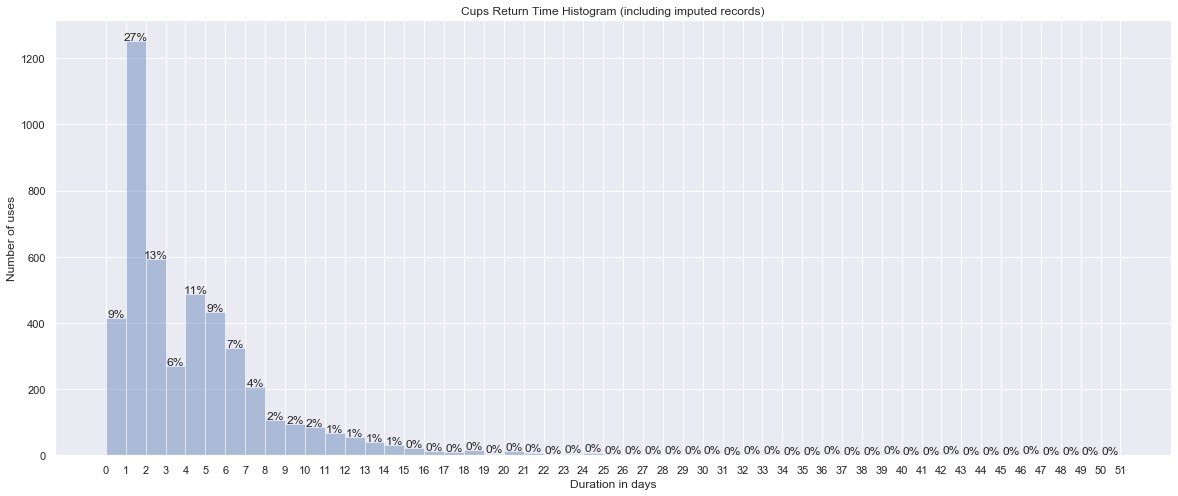

In [69]:
set(style="darkgrid")

fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)

# histogram plot
max_days_value = ceil(max(durations)) + 1
distplot(a=durations, hist=True, kde=False, rug=False, bins=range(max_days_value))

# Setting the X and Y Label 
plt.xlabel('Duration in days') 
plt.ylabel('Number of uses')

# setting the X and Y ticks
plt.xticks(np.arange(0, max_days_value))
#plt.yticks(np.arange(0, 850, 50))

# setting the title
plt.title('Cups Return Time Histogram (including imputed records)')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1}%'.format(int(round(height/len(durations)*100))),
            ha="center") 

plt.show()

In [70]:
# logic to cap all durations above 20 to 20.1 (to be boxed in 20-21 bin in the histogram)
for index in range(len(durations)):
    if durations[index] > 20:
        durations[index] = 20.1

In [71]:
# name of the dataset
group_labels = ['Cups return time']

fig = ff.create_distplot([np.array(durations)], group_labels, show_rug=False, bin_size=1)
fig.update_layout(xaxis=dict(range=[-1, ceil(max(durations))+1]))

fig.update_layout(
    title="Histogram with probability density curve for cups return time (with imputations)",
    xaxis_title="Duration in days",
    yaxis_title="Probability density",
    xaxis = dict(tickmode = 'linear'),
    annotations=[dict(
                      x=0,
                      y=1.1,
                      showarrow=False,
                      text="Instances where the cup returned after 20 days have been boxed in 20-21 days bin.",
                      xref="paper",
                      yref="paper",
                      align="left"
                    )]
    )

fig.update_traces(marker=dict(line=dict(width=1,
                                        color='Black')),
                  nbinsx=21, 
                  autobinx=True, 
                  selector={'type':'histogram'}
                  )

counts, bins = np.histogram(durations, bins=range(0, 22, 1))
height = round(max(counts)/sum(counts),2)
percents = [int(round(count/len(durations)*100)) for count in counts]

fig.add_trace(Scatter(
    x=[ceil(max(durations))],
    y=[height],
    mode="text",
    text='Total uses: {}'.format(len(durations)),
    textposition="top left",
    showlegend=False
))

fig.add_trace(Scatter(
    x=np.arange(0.5, ceil(max(durations)), 1),
    y=[round(count/len(durations),4)+0.005 for count in counts],
    mode="text",
    text=[str(percent) + '%' for percent in percents],
    textposition="top center",
    showlegend=False,
    hoverinfo='skip'
))


fig.show()

In [72]:
durations.sort()
frame = DataFrame({'duration': durations})
frame.to_csv('./data files/durationsImputed.csv', index = False)